# **Mini-Projet : Analyse des Sentiments dans les Avis**

**Import libraries**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import nltk
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Import data**

In [35]:
# Charger le fichier CSV

data = pd.read_csv("/content/IMDB Dataset.csv", on_bad_lines='skip', engine='python')

# Afficher un aperçu des données

print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [36]:
#summary of data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [37]:
#total columns and rows
print("le nombre des colonnes",data.shape[0])
print("le nombre des lignes",data.shape[1])

le nombre des colonnes 50000
le nombre des lignes 2


In [38]:
#statistiqe summary of the data
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [39]:
#sentiemnt counts of positive and negative values
sentiment_counts=data.sentiment.value_counts()
sentiment_counts

,count
sentiment,
positive,25000
negative,25000


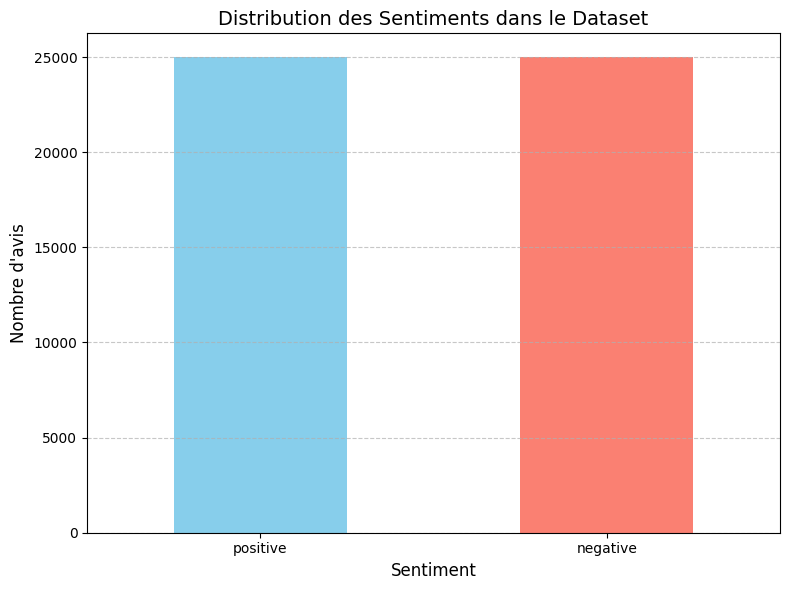

In [40]:
# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add titles and labels
plt.title('Distribution des Sentiments dans le Dataset', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Nombre d\'avis', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [41]:
# Check for null values in the dataset
null_values = data.isnull().sum()

null_values

,0
review,0
sentiment,0


In [42]:
#Function that calculates the number of words in each review
def number_of_word(text):
  split_text=text.split()
  word_count=len(split_text)
  return word_count
data['word_count']=data['review'].apply(number_of_word)
data.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


In [43]:
#number of duplicate values
duplicated_count=data.duplicated().sum()
print("le nombre des doublons",duplicated_count)

le nombre des doublons 418


In [44]:
#Delete duplicate numbers
data=data.drop_duplicates()

**Display moste frequent words in positive reviews**

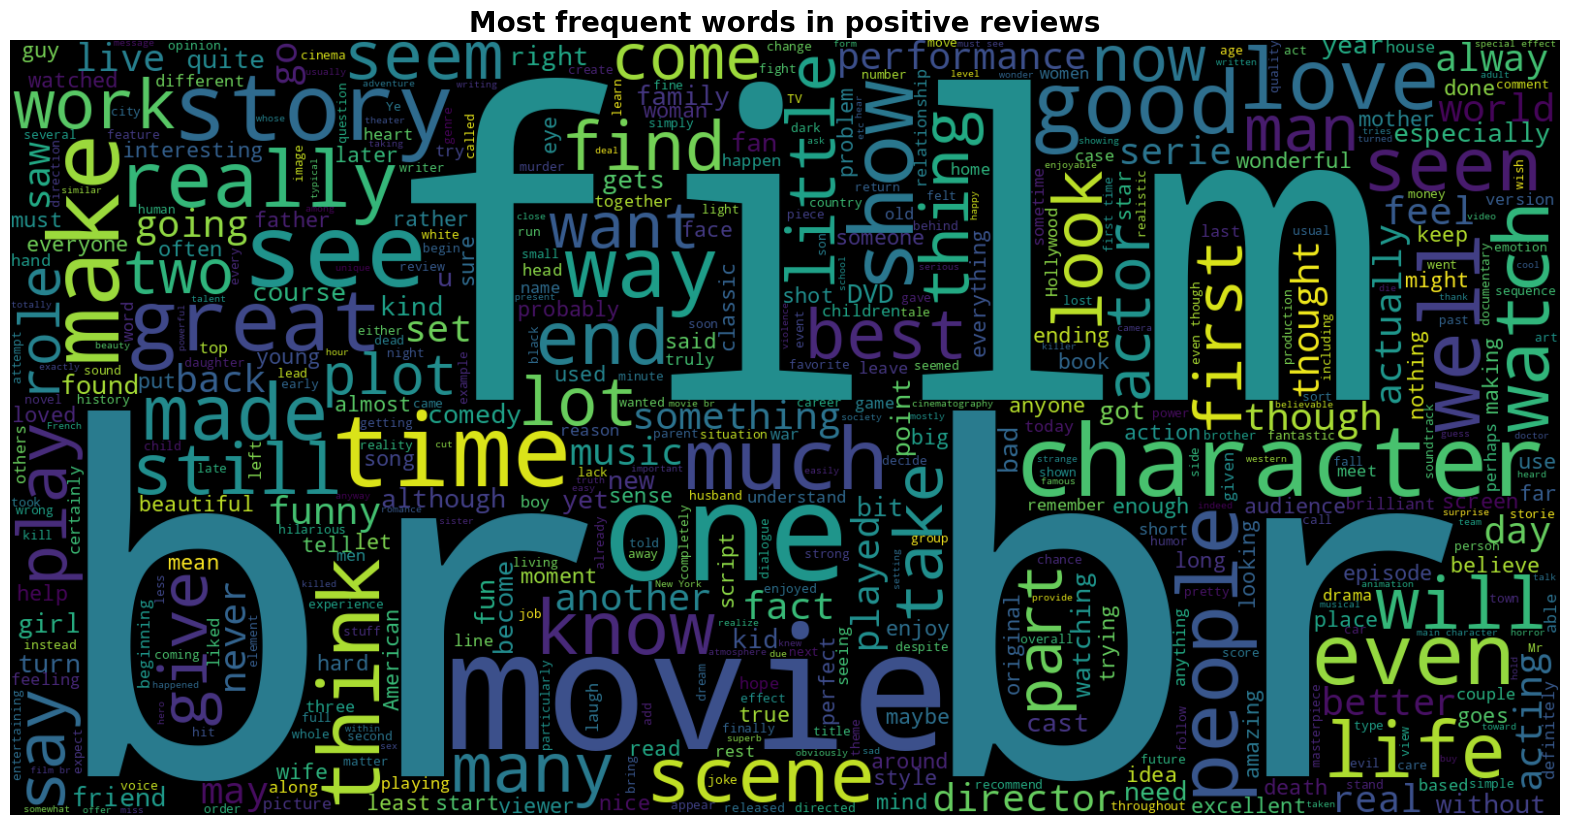

In [45]:
data_positive=data[data['sentiment']=='positive']
text = ' '.join([word for word in data_positive.review])
plt.figure(figsize=(20, 15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize=20, fontweight='bold')
plt.show()


**Display moste frequent words in negative reviews**

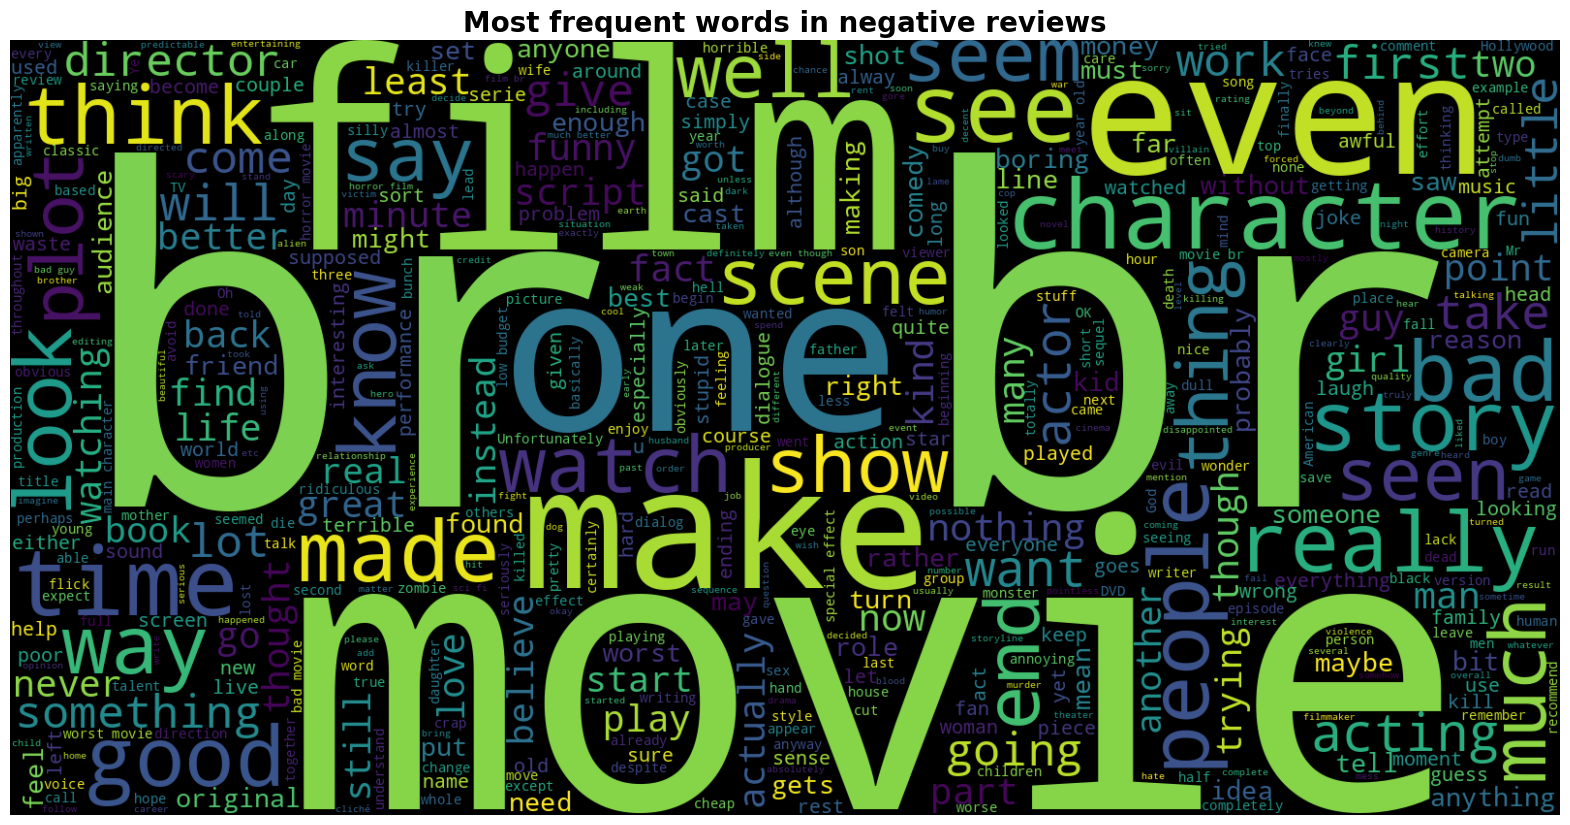

In [46]:
#display moste frequent words in negative reviews
data_negative=data[data['sentiment']=='negative']
text = ' '.join([word for word in data_negative.review])
plt.figure(figsize=(20, 15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize=20, fontweight='bold')
plt.show()


**Preprocessing data**

In [47]:
#Preprocessing
def data_preprocessing(text):
    text = text.lower()  # Convert to lowercase
    text = pd.Series(text).str.replace('<[^<]+?>', '', regex=True).item()  # Remove HTML tags
    text = pd.Series(text).str.replace(r'[^\w\s]', '', regex=True).item()  # Remove punctuation
    text = pd.Series(text).str.replace(r'https?://\S+|www\.\S+', '', regex=True).item()  # Remove URLs
    stop_words = set(stopwords.words('english')) #Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [48]:
# Applying the function to the 'review' column
data['review'] = data['review'].apply(data_preprocessing)

In [50]:
data.iloc[0].review

'one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle 

In [51]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatization(data):
    # Lemmatize each word in the data
    text = [lemmatizer.lemmatize(word) for word in data]
    return text

In [52]:
# Apply lemmatization on the 'review' column
data['review'] = data['review'].apply(lambda x: lemmatization(x))


**la méthode TF-IDF**

In [53]:
x=data['review']
y=data['sentiment']
data['review'] = data['review'].apply(lambda x: ''.join(x))


In [54]:
#vectorizer = TfidfVectorizer(max_features=2000)
vectorizer = TfidfVectorizer(max_features=2500, ngram_range=(1, 2))
x = vectorizer.fit_transform(data['review']).toarray()

**Division des données**

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [56]:
print("the size of x_train:",x_train.shape)
print("the size of x_test:",x_test.shape)
print("the size of y_train:",y_train.shape)
print("the size of y_test:",y_test.shape)

the size of x_train: (39665, 2500)
the size of x_test: (9917, 2500)
the size of y_train: (39665,)
the size of y_test: (9917,)


**Entraînement du modèle**

In [57]:
logreg=LogisticRegression()

In [58]:
logreg.fit(x_train,y_train)

LogisticRegression()

In [59]:
logreg_pred=logreg.predict(x_test)

In [60]:
logreg_acc=accuracy_score(y_test,logreg_pred)
print("the accuracy of the model is:{:.2f}%".format(logreg_acc*100))

the accuracy of the model is:88.28%


**Évaluation du modèle**

In [61]:
print(classification_report(y_test,logreg_pred))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4939
    positive       0.87      0.90      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



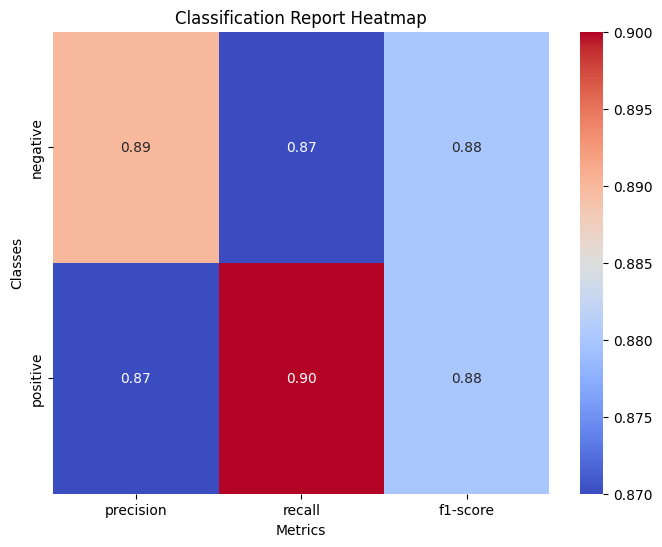

In [62]:
# Data from the classification report
classes = ["negative", "positive"]
metrics = ["precision", "recall", "f1-score"]
values = np.array([
    [0.89, 0.87, 0.88],  # Negative
    [0.87, 0.90, 0.88],  # Positive
])

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(values, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=metrics, yticklabels=classes)
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

In [63]:
#the confusion matrix
confusion_matrix(y_test,logreg_pred)

array([[4288,  651],
       [ 511, 4467]])

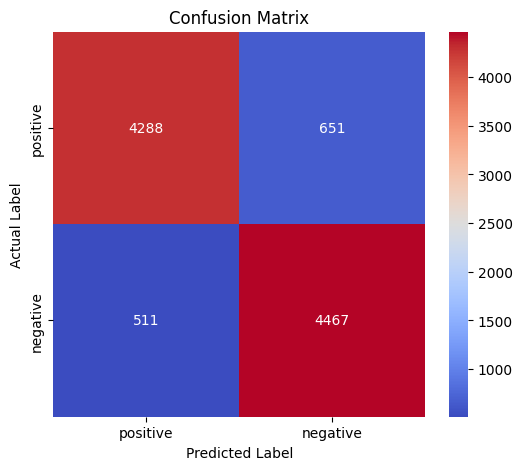

In [64]:
#display confusion matrix
cm=confusion_matrix(y_test,logreg_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()